## AIMI High School Internship 2024
### Notebook 2: Training a Computer Vision Model to Classify Pneumonia

**The Problem**: Given a chest X-ray, our goal in this project is to classify the image into one of four classes: **pneumonia, pneumothorax, pleural effusion**, and **normal**.  

**Your Second Task**: You should now have a training dataset consisting of (a) chest X-rays and (b) labels extracted from radiologist reports processed using NLP or a similar technique. Now, your goal is to train a computer vision model to classify the images. You have **two options** for this task, and you may attempt one or both of these:
- *Standard Classification* : Train a model to predict which class of pneumonia a chest x-ray belongs to using image-only derived features.
- *Classification w/ Metadata (stretch)*: Train a model that predicts which class of pneumonia a chest x-ray belongs to using image and additional patient metadata-derived features.

In this notebook, we provide some simple starter code to get you started on training a computer vision model. You are not required to use this template - feel free to modify as you see fit.

**Submitting Your Model**: We have created a leaderboard where you can submit your model and view results on the held-out test set. We provide instructions below for submitting your model to the leaderboard. **Please follow these directions carefully**.

We will evaluate your results on the held-out test set with the following evaluation metrics:
- **Accuracy**: the ratio of correctly predicted observations to the total observations. It tells us the proportion of true results (both true positives and true negatives) among the total number of cases examined. While straightforward, accuracy can be misleading in the context of imbalanced datasets where the number of observations in different classes varies significantly.
- **AUROC (Area Under the Receiver Operating Characteristic curve)**: a performance measurement for classification problems at various threshold settings. It tells us how well a model is capable of distinguishing between classes. The higher the AUROC, the better the model is at predicting 0s as 0s and 1s as 1s. An AUROC of 0.5 suggests no discriminative ability (equivalent to random guessing), while an AUROC of 1.0 indicates perfect discrimination.
- **Precision**: the ratio of correctly predicted positive observations to the total predicted positives. It is a measure of a classifier's exactness. High precision indicates a low false positive rate. It's particularly useful when the costs of False Positives are high.
- **Recall**: (also known as sensitivity) the ratio of correctly predicted positive observations to the all observations in actual class - yes. It is a measure of a classifier's completeness. High recall indicates that the class is correctly recognized (a low number of False Negatives).
- **F1**: the harmonic mean of precision and recall. It's a way to combine both precision and recall into a single measure that captures both properties. This score can be particularly useful if you need to balance precision and recall, which is often the case in uneven class distribution scenarios. The F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0.

## Load Data
Before you begin, make sure to go to `Runtime` > `Change Runtime Type` and select a T4 GPU.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
# TO DO: update this path to point wherever the `2024 AIMI Summer Internship - Intern Materials/Datasets/`
# is stored for you (e.g. add a shortcut of the folder your Drive and point to that location)
## To do this, clicking the folder icon on the left, select drive, select MyDrive,
## navigate to wherever official AIMI folder is stored on your Drive (you should've added it as a shortcut),
## find the Datasets subfolder and click the 3 vertical dots next to it, select Copy path and paste it below.
os.chdir(r'/content/drive/MyDrive/2024 AIMI Summer Internship - Intern Materials/Datasets')

In [ ]:
!unzip -qq student_data_split.zip -d /content/

In [ ]:
# Switch back to /content/student_data_split folder to work with downloaded datasets
os.chdir(r'/content/student_data_split')

In [ ]:
# Confirm we can now see the student_test and student_train folders + Reports.json
!ls

Reports.json  student_test  student_train


## Import Libraries
We are leveraging the PyTorch framework to train our models. For more information and tutorials on PyTorch, see this link: https://pytorch.org/tutorials/beginner/basics/intro.html

In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

In [ ]:
# Some libraries that you may find useful are included here.
# To import a library that isn't provided with Colab, use the following command: !pip install <package_name>
import torch
import pandas as pd
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import roc_auc_score
from torchvision import transforms

In [ ]:
pwd()

'/content/student_data_split'

In [ ]:
## TO DO
# Load your image paths and extracted labels from your saved file
dataset = pd.read_csv('train_annotations_with_label.csv') # Be sure to upload your downloaded file first by clicking the file icon on the right, drag & drop
indices_to_remove = []

for idx in range(len(dataset)):
    img_name = 'student_' + str(dataset.iloc[idx, 0]) + '/view1_frontal.jpg'
    if not os.path.exists(img_name):
        indices_to_remove.append(idx)

dataset = dataset.drop(indices_to_remove).reset_index(drop=True)
dataset = dataset.replace(-1, 1, inplace=False)
# Display the first few rows of the DataFrame to confirm it's loaded correctly


## Create Dataloaders
We will implement a custom Dataset class to load in data. A custom Dataset class must have three methods: `__init__`, which sets up any class variables, `__len__`, which defines the total number of images, and `__getitem__`, which returns a single image and its paired label.

In [ ]:
from sklearn.utils import resample

In [ ]:
#only predict Pneumonia

columns_to_keep = ['study_id','Pneumonia']

# Selecting the columns

data_pneumonia=dataset[columns_to_keep]

In [ ]:
#only predict Pneumonia

columns_to_keep = ['study_id','Pneumothorax']

# Selecting the columns

data_pneumothorax=dataset[columns_to_keep]


In [ ]:
columns_to_keep2 = ['study_id','No Finding']

# Selecting the columns

data_normal=dataset[columns_to_keep2]

In [ ]:
columns_to_keep3 = ['study_id','Pleural Effusion']

# Selecting the columns

data_pe=dataset[columns_to_keep3]

In [ ]:
class ChestXRayDataset(Dataset):
    def __init__(self, data, transform=None):
        super(ChestXRayDataset, self).__init__()
        self.data = data

        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = 'student_' + str(self.data.iloc[idx, 0]) + '/view1_frontal.jpg'
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        labels = self.data.iloc[idx, 1:].values.astype('float')
        labels = torch.tensor(labels)

        out_dict = {
            "idx": torch.tensor(idx),
            "img": image,
            "label": labels
        }

        return out_dict

## Define Training Components
Here, define any necessary components that you need to train your model, such as the model architecture, the loss function, and the optimizer.

In [ ]:
class CustomEfficientNet(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CustomEfficientNet, self).__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(0.5)
        self.bn = nn.BatchNorm1d(num_classes)
        self.fc = nn.Linear(base_model._fc.in_features, num_classes)

    def forward(self, x):
        x = self.base_model.extract_features(x)
        x = self.base_model._avg_pooling(x)
        x = x.flatten(start_dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.bn(x)
        return x

In [229]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = nn.BCEWithLogitsLoss()# Loss Function
#model = ImprovedCNN()
model=EfficientNet.from_pretrained('efficientnet-b0')
num_classes = 1  # Number of output classes
model._fc = nn.Linear(model._fc.in_features, num_classes)
custom_model = CustomEfficientNet(model, num_classes)
custom_model = custom_model.to(device)
opt = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-2) # AdamW is a commonly-used optimizer. Feel free to modify.

#opt = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3) # AdamW is a commonly-used optimizer. Feel free to modify.


Loaded pretrained weights for efficientnet-b0


## Visualizations
- Create some visualizations to highlight model performance e.g. `multilabel_confusion_matrix`, plot of train vs val loss history, plot of train vs val accuracy history.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support

In [238]:
train, val_df = train_test_split(data_pneumothorax, test_size=0.2, random_state=221)
print(train.shape, val_df.shape)
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.485, 0.485], std = [0.229, 0.224, 0.225])])

train_dataset = ChestXRayDataset(train, transform=transform)
val_dataset = ChestXRayDataset(val_df, transform=transform)

batch_size = 2
#batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

(10170, 2) (2543, 2)


## Training Code
We provide starter code below that implements a simple training loop in PyTorch. Feel free to modify as you see fit.

In [ ]:
#print((train_dataset.data['No Finding'] == 1).sum())

In [ ]:
##print((train_dataset.data['Pleural Effusion'] == 1).sum())
print((train_dataset.data['Pneumonia'] == 1).sum())
#print((train_dataset.data['Pneumothorax'] == 1).sum())
#print((train_dataset.data['No Finding'] == 1).sum())

917


In [ ]:
# def train_eval(model, loss_fn, train_loader, val_loader, optimizer, device, max_epoch):
#     best_val_loss = np.inf
#     best_val_metrics = []

#     for epoch in range(max_epoch):
#         model.train()  # Set model to training mode

#         train_loss = train(model, loss_fn, train_loader, val_loader, optimizer, device, max_epoch)

#         # Save best model based on validation loss
#         val_loss = val(model, val_loader, loss_fn, device)

#         print(f"Epoch {epoch+1}/{max_epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             torch.save(model.state_dict(), 'best_model_1.pth')  # Save the best model
#             print(f"Saved new best model at epoch {epoch+1}")
#         return label_train,pred_train,label_val,pred_val
# # Training step per epoch
# def train(model, loss_fn, train_loader, val_loader, optimizer, device, max_epoch):
#   total_loss = 0
#   print(len(train_loader))
#   pred_train=[]
#   label_train=[]
#   for step, sample in tqdm(enumerate(train_loader)):
#       imgs, labels = sample['img'], sample['label']  # Extract data and labels from the batch
#       #print(f"Batch {step+1}, Image shape: {imgs.shape}, Labels shape: {labels.shape}")
#       imgs = imgs.to(device)
#       labels = labels.to(device)
#       label_train.append(labels)


#       optimizer.zero_grad()  # Clear previous gradients
#       preds = model(imgs)  # Compute prediction
#       pred_train.append(preds)



#       loss = loss_fn(preds, labels)  # Compute loss
#       total_loss += loss.item()

#       loss.backward()  # Backpropagate the loss
#       optimizer.step()  # Update the weights

#       if step % 10 == 0:  # Print every 10 batches
#             print(f"At batch {step}, Current Loss: {loss.item()}")

#   avg_loss = total_loss / len(train_loader)
#   print(f"Total training loss: {total_loss}, Average Loss: {avg_loss}")
#   return avg_loss, label_train,pred_train

# # Validation step, can be used for finetuning
# def val(model, val_loader, loss_fn, device):
#     model.eval()  # Set model to evaluation mode
#     total_val_loss = 0
#     with torch.no_grad():  # Disable gradient calculation
#         pred_val=[]
#         label_val=[]
#         for sample in val_loader:
#             imgs, labels = sample['img'], sample['label']
#             imgs = imgs.to(device)
#             labels = labels.to(device)
#             label_val.append(labels)



#             preds = model(imgs)
#             pred_val.append(preds)
#             loss = loss_fn(preds, labels)
#             total_val_loss += loss.item()

#     avg_val_loss = total_val_loss / len(val_loader)
#     return avg_val_loss, label_val,pred_val   # Replace [] with actual validation metrics if necessary

In [239]:
def train_eval(model, loss_fn, train_loader, val_loader, optimizer, device, max_epoch):
    best_val_loss = np.inf
    best_val_metrics = []

    for epoch in range(max_epoch):
        model.train()  # Set model to training mode

        #train_loss = train(model, loss_fn, train_loader, val_loader, optimizer, device, max_epoch)
        train_loss,label_train,pred_train= train(model, loss_fn, train_loader, val_loader, optimizer, device, max_epoch)

        # Save best model based on validation loss
        val_loss,label_val,pred_val  = val(model, val_loader, loss_fn, device)

        print(f"Epoch {epoch+1}/{max_epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_Pneumothorax.pth')  # Save the best model
            print(f"Saved new best model at epoch {epoch+1}")
        return label_train,pred_train

# Training step per epoch
def train(model, loss_fn, train_loader, val_loader, optimizer, device, max_epoch):
  total_loss = 0
  print(len(train_loader))
  pred_train=[]
  label_train=[]
  for step, sample in tqdm(enumerate(train_loader)):
      imgs, labels = sample['img'], sample['label']  # Extract data and labels from the batch
      #print(f"Batch {step+1}, Image shape: {imgs.shape}, Labels shape: {labels.shape}")
      imgs = imgs.to(device)
      labels = labels.to(device)
      label_train.append(labels)



      optimizer.zero_grad()  # Clear previous gradients
      preds = model(imgs)  # Compute prediction
      pred_train.append(preds)


      loss = loss_fn(preds, labels)  # Compute loss
      total_loss += loss.item()

      loss.backward()  # Backpropagate the loss
      optimizer.step()  # Update the weights

      if step % 10 == 0:  # Print every 10 batches
            print(f"At batch {step}, Current Loss: {loss.item()}")

  avg_loss = total_loss / len(train_loader)
  print(f"Total training loss: {total_loss}, Average Loss: {avg_loss}")
  return avg_loss, label_train,pred_train

# Validation step, can be used for finetuning
def val(model, val_loader, loss_fn, device):
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():  # Disable gradient calculation
        pred_val=[]
        label_val=[]
        for sample in val_loader:
            imgs, labels = sample['img'], sample['label']
            imgs = imgs.to(device)
            labels = labels.to(device)
            label_val.append(labels)

            preds = model(imgs)
            pred_val.append(preds)


            loss = loss_fn(preds, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    return avg_val_loss , label_val,pred_val # Replace [] with actual validation metrics if necessary

In [240]:
opt = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=3e-2)

In [242]:
label_train, pred_train=train_eval(model, loss, train_loader, val_loader, opt, device, max_epoch=10)

5085


0it [00:00, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB. GPU 

In [248]:
model = EfficientNet.from_pretrained('efficientnet-b0')
num_classes = 4  # Number of output classes
model._fc = nn.Linear(model2._fc.in_features, num_classes)

Loaded pretrained weights for efficientnet-b0


In [250]:
device = torch.device("cpu")

In [251]:
ckpt = torch.load("./best_model_all.pth", map_location = device)
model.load_state_dict(ckpt)

<All keys matched successfully>

In [ ]:
model.eval()  # Set model to evaluation mode
preds = []
pred_proba = []
labels2 = []
with torch.no_grad():
  for sample in val_loader:
    imgs, labels = sample['img'], sample['label']
    imgs = imgs.to(device)
    labels = labels.to(device)
    labels2.append(labels)

    preds = model(imgs)
    pred_val.append(preds)


    loss = loss_fn(preds, labels)
    total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    img = Image.open(path)
    img = transform(img)
    img = img.unsqueeze(0).to(device)
    outputs = F.sigmoid(model(img))
    predicted_labels = (outputs > 0.5).long()  # Threshold probabilities to get binarized outputs

    preds.extend(predicted_labels.cpu().numpy())
    pred_proba.extend(outputs.cpu().numpy())

In [ ]:
Pneumonia

In [ ]:
final_array=np.empty((0, pred_train[0].shape[1]))
for i in range(len(pred_train)):
  ar=pred_train[i].cpu().detach().numpy()
  final_array=np.concatenate((final_array,ar),axis=0)
df_pred_train_Pneumonia=pd.DataFrame(final_array,columns=['Pneumonia_pred'])
df_pred_train_Pneumonia.to_csv(f"./train_preds_Pneumonia.csv")

In [ ]:
final_array=np.empty((0, label_train[0].shape[1]))
for i in range(len(label_train)):
  ar=label_train[i].cpu().detach().numpy()
  final_array=np.concatenate((final_array,ar),axis=0)
df_label_train_Pneumonia=pd.DataFrame(final_array,columns=['Pneumonia_label'])
df_label_train_Pneumonia.to_csv(f"./train_labels_Pneumonia.csv")

In [ ]:
#random forest to predict

In [ ]:
#processing data

In [ ]:
df_label_train_all=pd.read_csv('./label_preds.csv')
df_pred_train_all=pd.read_csv('./train_preds.csv')

In [ ]:
df_pred_train_Pneumothorax=df_pred_train
df_label_train_Pneumothorax=df_label_train

In [ ]:
df_pred_train_Pneumonia
df_label_train_Pneumonia

In [ ]:
df_label_train_all.shape

(10170, 5)

In [ ]:
df_label_train_all.head()

,Unnamed: 0,Pneumothorax,Pneumonia,Pleural Effusion,No Finding
0,0,1.0,0.0,0.0,0.0
1,1,0.0,1.0,1.0,0.0
2,2,0.0,0.0,0.0,1.0
3,3,0.0,0.0,0.0,1.0
4,4,0.0,0.0,0.0,1.0


In [ ]:
df_label_train_all_keep=df_label_train_all[['Pleural Effusion','No Finding']]

In [ ]:
df_label_train_all_keep.rename(columns={'Pleural Effusion': 'Pleural_Effusion_Label', 'No Finding': 'No_Finding_label' }, inplace=True)



<ipython-input-47-d7c929e7fbe2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_label_train_all_keep.rename(columns={'Pleural Effusion': 'Pleural_Effusion_Label', 'No Finding': 'No_Finding_label' }, inplace=True)


In [ ]:
df_label_train_all_keep.head()

,Pleural_Effusion_Label,No_Finding_label
0,0.0,0.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


In [ ]:
df_pred_train_all.shape

(10170, 5)

In [ ]:
df_pred_train_all_keep=df_pred_train_all[['Pleural Effusion','No Finding']]
df_pred_train_all_keep.rename(columns={'Pleural Effusion': 'Pleural_Effusion_Pred', 'No Finding': 'No_Finding_Pred' }, inplace=True)


<ipython-input-49-2253600e6f14>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_train_all_keep.rename(columns={'Pleural Effusion': 'Pleural_Effusion_Pred', 'No Finding': 'No_Finding_Pred' }, inplace=True)


In [ ]:
df_pred_train_all_keep.head()

,Pleural_Effusion_Pred,No_Finding_Pred
0,-0.122741,0.171688
1,-0.164747,-0.052202
2,0.227437,0.004850
3,-0.064083,0.097921
4,0.111145,0.192746


In [ ]:
df_pred_train_all_keep_new = df_pred_train_all_keep.applymap(lambda x: 0 if x < 0.5 else 1)


In [ ]:
df_pred_train_all_keep_new.head()

,Pleural_Effusion_Pred,No_Finding_Pred
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [ ]:
df_pred_train_all_keep_new['Pleural_Effusion_Pred'].value_counts()

Pleural_Effusion_Pred
0    10028
1      142
Name: count, dtype: int64

In [ ]:
df_pred_train_all_keep_new['No_Finding_Pred'].value_counts()

No_Finding_Pred
1    7547
0    2623
Name: count, dtype: int64

In [ ]:
df_pred_train_Pneumothorax
df_label_train_Pneumothorax

In [ ]:
df_pred_train_Pneumothorax.rename(columns={'Pneumothorax': 'Pneumothorax_Pred' }, inplace=True)
df_label_train_Pneumothorax.rename(columns={'Pneumothorax': 'Pneumothorax_Label' }, inplace=True)


In [ ]:
df_pred_train_Pneumothorax_new = df_pred_train_Pneumothorax.applymap(lambda x: 0 if x < 0.5 else 1)

In [ ]:
df_pred_train_Pneumothorax_new.head()

,Pneumothorax_Pred
0,0
1,0
2,0
3,0
4,0


In [ ]:
df_label_train_Pneumonia
df_pred_train_Pneumonia

In [ ]:
df_pred_train_Pneumonia.rename(columns={'Pneumonia': 'Pneumonia_Pred' }, inplace=True)
df_label_train_Pneumonia.rename(columns={'Pneumonia': 'Pneumonia_Label' }, inplace=True)


In [ ]:
df_pred_train_Pneumonia.head()

,Pneumonia_pred
0,-0.508134
1,-2.886902
2,-0.720975
3,-2.752832
4,-0.599603


In [ ]:
df_pred_train_Pneumonia_new = df_pred_train_Pneumonia.applymap(lambda x: 0 if x < 0.5 else 1)

In [ ]:
df_pred_train_Pneumonia_new.head()

,Pneumonia_pred
0,0
1,0
2,0
3,0
4,0


In [ ]:
df_pred_train_Pneumonia_new['Pneumonia_pred'].value_counts()

Pneumonia_pred
0    10150
1       20
Name: count, dtype: int64

In [ ]:
df_label_train_Pneumonia['Pneumonia_label'].value_counts()

Pneumonia_label
0.0    9253
1.0     917
Name: count, dtype: int64

In [ ]:
df_pred_train_Pneumothorax.head()

,Pneumothorax_Pred
0,-5.156095
1,-3.820392
2,-3.979391
3,-3.286363
4,-2.225475


In [ ]:
df_pred_train_Pneumothorax_new=df_pred_train_Pneumothorax.applymap(lambda x: 0 if x < 0.5 else 1)

In [ ]:
df_pred_train_Pneumothorax_new.head()

,Pneumothorax_Pred
0,0
1,0
2,0
3,0
4,0


In [ ]:
df_pred_train_Pneumothorax_new.value_counts()

Pneumothorax_Pred
0                    10157
1                       13
Name: count, dtype: int64

In [ ]:
#conbine all data together

In [ ]:
combined_df = pd.concat([df_pred_train_Pneumothorax_new,
                         df_label_train_Pneumothorax,

                         df_pred_train_Pneumonia_new,
                         df_label_train_Pneumonia,

                         df_pred_train_all_keep_new,
                         df_label_train_all_keep

                         ], axis=1)

In [ ]:
combined_df = pd.concat([df_pred_train_Pneumothorax,
                         df_label_train_Pneumothorax,

                         df_pred_train_Pneumonia,
                         df_label_train_Pneumonia,

                         df_pred_train_all_keep,
                         df_label_train_all_keep

                         ], axis=1)

In [ ]:
combined_df.head()

,Pneumothorax_Pred,Pneumothorax_Label,Pneumonia_pred,Pneumonia_label,Pleural_Effusion_Pred,No_Finding_Pred,Pleural_Effusion_Label,No_Finding_label
0,-5.156095,0.0,-0.508134,0.0,-0.122741,0.171688,0.0,0.0
1,-3.820392,0.0,-2.886902,0.0,-0.164747,-0.052202,1.0,0.0
2,-3.979391,0.0,-0.720975,0.0,0.227437,0.004850,0.0,1.0
3,-3.286363,0.0,-2.752832,0.0,-0.064083,0.097921,0.0,1.0
4,-2.225475,0.0,-0.599603,0.0,0.111145,0.192746,0.0,1.0


In [ ]:
combined_df.shape

(10170, 8)

In [ ]:
combined_df.head()

,Pneumothorax_Pred,Pneumothorax_Label,Pneumonia_pred,Pneumonia_label,Pleural_Effusion_Pred,No_Finding_Pred,Pleural_Effusion_Label,No_Finding_label
0,0,0.0,0,0.0,0,0,0.0,0.0
1,0,0.0,0,0.0,0,0,1.0,0.0
2,0,0.0,0,0.0,0,0,0.0,1.0
3,0,0.0,0,0.0,0,0,0.0,1.0
4,0,0.0,0,0.0,0,0,0.0,1.0


In [ ]:
combined_df_keep=combined_df[['Pneumonia_label','Pleural_Effusion_Pred','No_Finding_Pred','Pneumonia_pred']]

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score


# Separate the features (X) and the target variable (y)
X = combined_df_keep[['Pleural_Effusion_Pred', 'No_Finding_Pred','Pneumonia_pred']]
y = combined_df_keep['Pneumonia_label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=221)

# Train the Random Forest model
clf = RandomForestClassifier(random_state=221)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC: {auc}")

# Print the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)


Accuracy: 0.9228121927236972
Precision: 0.5853658536585366
Recall: 0.2807017543859649
F1 Score: 0.3794466403162055
AUC: 0.8425227498877809
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96      1863
         1.0       0.59      0.28      0.38       171

    accuracy                           0.92      2034
   macro avg       0.76      0.63      0.67      2034
weighted avg       0.91      0.92      0.91      2034



In [ ]:
X_test.head()

,Pleural_Effusion_Pred,No_Finding_Pred,Pneumonia_pred
703,-1.485369,1.384837,-4.461340
3967,-1.831000,0.827390,-1.326431
6235,-1.485233,0.331543,-3.202626
9983,-7.316663,5.643204,-5.000599
4441,-4.576086,3.418639,-3.633226


In [ ]:
df_sumbit=pd.read_csv('./test_preds_new3.csv')

In [ ]:
df_sumbit.head()

,Unnamed: 0,study_id,image_path,Pneumothorax,Pneumonia,Pleural Effusion,No Finding,Pneumothorax Probs,Pneumonia Probs,Pleural Effusion Probs,No Finding Probs
0,0,student_test/patient35172/study3,./student_test/patient35172/study3/view1_front...,0,0,1,0,0.042089,0.088979,0.545931,0.084048
1,1,student_test/patient43229/study5,./student_test/patient43229/study5/view1_front...,1,0,1,0,0.664573,0.229251,0.541373,0.184606
2,2,student_test/patient21668/study3,./student_test/patient21668/study3/view1_front...,0,0,0,0,0.272357,0.033949,0.494880,0.196433
3,3,student_test/patient35880/study5,./student_test/patient35880/study5/view1_front...,1,0,0,0,0.502559,0.064727,0.361247,0.162480
4,4,student_test/patient59312/study1,./student_test/patient59312/study1/view1_front...,0,0,0,0,0.010281,0.302449,0.095928,0.424191


In [ ]:
df_submit_Pneumonia=df_sumbit[['Pleural Effusion Probs','No Finding Probs','Pneumonia Probs']]

In [ ]:
df_submit_Pneumonia.rename(columns={
                                    'Pleural Effusion Probs':'Pleural_Effusion_Pred',
                                    'No Finding Probs': 'No_Finding_Pred',

                                    'Pneumonia Probs':'Pneumonia_pred'

                                    }, inplace=True)


<ipython-input-142-fa0f1ac9d333>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_submit_Pneumonia.rename(columns={


In [ ]:
df_submit_Pneumonia.head()

,Pleural_Effusion_Pred,No_Finding_Pred,Pneumonia_pred
0,0.545931,0.084048,0.088979
1,0.541373,0.184606,0.229251
2,0.494880,0.196433,0.033949
3,0.361247,0.162480,0.064727
4,0.095928,0.424191,0.302449


In [ ]:
X_test_submit=df_submit_Pneumonia

In [ ]:
# Make predictions
y_pred = clf.predict(X_test_submit)
y_pred_proba = clf.predict_proba(X_test_submit)[:, 1]

In [ ]:
# Concatenate the numpy arrays horizontally (axis=1)
concatenated_array = np.column_stack((y_pred, y_pred_proba))

# Convert the concatenated array to a pandas DataFrame
df_Pneumonia = pd.DataFrame(concatenated_array)

# Rename the columns of the DataFrame
df_Pneumonia.columns = ['Pneumonia', 'Pneumonia Probs']

In [ ]:
df_Pneumonia.shape

(2983, 2)

In [ ]:
df_Pneumonia.head()

,Pneumonia,Pneumonia Probs
0,1.0,0.52
1,1.0,0.52
2,1.0,0.54
3,1.0,0.59
4,1.0,0.63


In [ ]:
combined_df_keep_Pneumothorax=combined_df[['Pneumothorax_Label','Pneumothorax_Pred','Pleural_Effusion_Pred','No_Finding_Pred']]

In [ ]:
combined_df_keep_Pneumothorax.head()

,Pneumothorax_Label,Pneumothorax_Pred,Pleural_Effusion_Pred,No_Finding_Pred
0,0.0,-5.156095,-0.122741,0.171688
1,0.0,-3.820392,-0.164747,-0.052202
2,0.0,-3.979391,0.227437,0.004850
3,0.0,-3.286363,-0.064083,0.097921
4,0.0,-2.225475,0.111145,0.192746


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score


# Separate the features (X) and the target variable (y)
X = combined_df_keep_Pneumothorax[['Pleural_Effusion_Pred', 'No_Finding_Pred','Pneumothorax_Pred']]
y = combined_df_keep_Pneumothorax['Pneumothorax_Label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=221)

# Train the Random Forest model
clf = RandomForestClassifier(random_state=221)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC: {auc}")

# Print the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)


Accuracy: 0.9223205506391348
Precision: 0.4931506849315068
Recall: 0.22929936305732485
F1 Score: 0.3130434782608696
AUC: 0.8631743974155806
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96      1877
         1.0       0.49      0.23      0.31       157

    accuracy                           0.92      2034
   macro avg       0.72      0.60      0.64      2034
weighted avg       0.90      0.92      0.91      2034



## Submitting Your Results
Once you have successfully trained your model, generate predictions on the test set and save your results as a `.pkl` file. This file can then be uploaded to the leaderboard.

Your final `.pkl` file **must** have the following format:
- There must be a column titled `image_path` with the paths to the test set images, e.g. `student_test/patient52331/study1/view1_frontal.jpg`.
- There must be a column titled `pred` with your model outputs.
  - This column must have an array of shape (4,) with floating point numbers ranging between 0 and 1 e.g. `array([0, 1, 0, 0])` or booleans e.g. `array([False,  True, False, False])`. Hint: You can convert model outputs to the 0 to 1 range by applying the sigmoid activation function (torch.nn.sigmoid())
- Double check that there are 1000 rows in your output file.

In [ ]:
df_submit_Pneumothorax=df_sumbit[['Pleural Effusion Probs','No Finding Probs','Pneumothorax Probs']]
df_submit_Pneumothorax.rename(columns={
                                    'Pleural Effusion Probs':'Pleural_Effusion_Pred',
                                    'No Finding Probs': 'No_Finding_Pred',

                                    'Pneumothorax Probs':'Pneumothorax_Pred'

                                    }, inplace=True)
X_test_submit=df_submit_Pneumothorax

<ipython-input-167-ca7cc6e741ab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_submit_Pneumothorax.rename(columns={


In [ ]:
X_test_submit.head()

,Pleural_Effusion_Pred,No_Finding_Pred,Pneumothorax_Pred
0,0.545931,0.084048,0.042089
1,0.541373,0.184606,0.664573
2,0.494880,0.196433,0.272357
3,0.361247,0.162480,0.502559
4,0.095928,0.424191,0.010281


In [ ]:



# Make predictions
y_pred = clf.predict(X_test_submit)
y_pred_proba = clf.predict_proba(X_test_submit)[:, 1]
# Concatenate the numpy arrays horizontally (axis=1)
concatenated_array = np.column_stack((y_pred, y_pred_proba))

# Convert the concatenated array to a pandas DataFrame
df_Pneumothorax = pd.DataFrame(concatenated_array)

# Rename the columns of the DataFrame
df_Pneumothorax.columns = ['Pneumothorax', 'Pneumothorax Probs']

df_Pneumothorax.shape




(2983, 2)

In [ ]:
df_Pneumothorax.head()

,Pneumothorax,Pneumothorax Probs
0,1.0,0.59
1,1.0,0.83
2,1.0,0.82
3,1.0,0.80
4,1.0,0.60


In [ ]:
df_sumbit.head()

,Unnamed: 0,study_id,image_path,Pneumothorax,Pneumonia,Pleural Effusion,No Finding,Pneumothorax Probs,Pneumonia Probs,Pleural Effusion Probs,No Finding Probs
0,0,student_test/patient35172/study3,./student_test/patient35172/study3/view1_front...,0,0,1,0,0.042089,0.088979,0.545931,0.084048
1,1,student_test/patient43229/study5,./student_test/patient43229/study5/view1_front...,1,0,1,0,0.664573,0.229251,0.541373,0.184606
2,2,student_test/patient21668/study3,./student_test/patient21668/study3/view1_front...,0,0,0,0,0.272357,0.033949,0.494880,0.196433
3,3,student_test/patient35880/study5,./student_test/patient35880/study5/view1_front...,1,0,0,0,0.502559,0.064727,0.361247,0.162480
4,4,student_test/patient59312/study1,./student_test/patient59312/study1/view1_front...,0,0,0,0,0.010281,0.302449,0.095928,0.424191


In [ ]:
# Drop columns 'Column2' and 'Column4'
df_sumbit.drop(['Pneumothorax','Pneumothorax Probs'], axis=1, inplace=True)

In [ ]:
df_sumbit.head()

,Unnamed: 0,study_id,image_path,Pneumonia,Pleural Effusion,No Finding,Pneumonia Probs,Pleural Effusion Probs,No Finding Probs
0,0,student_test/patient35172/study3,./student_test/patient35172/study3/view1_front...,0,1,0,0.088979,0.545931,0.084048
1,1,student_test/patient43229/study5,./student_test/patient43229/study5/view1_front...,0,1,0,0.229251,0.541373,0.184606
2,2,student_test/patient21668/study3,./student_test/patient21668/study3/view1_front...,0,0,0,0.033949,0.494880,0.196433
3,3,student_test/patient35880/study5,./student_test/patient35880/study5/view1_front...,0,0,0,0.064727,0.361247,0.162480
4,4,student_test/patient59312/study1,./student_test/patient59312/study1/view1_front...,0,0,0,0.302449,0.095928,0.424191


In [ ]:
df_sumbit_combined = pd.concat([df_sumbit,df_Pneumothorax ], axis=1)

In [ ]:
df_sumbit_combined.head()

,Unnamed: 0,study_id,image_path,Pneumonia,Pleural Effusion,No Finding,Pneumonia Probs,Pleural Effusion Probs,No Finding Probs,Pneumothorax,Pneumothorax Probs
0,0,student_test/patient35172/study3,./student_test/patient35172/study3/view1_front...,0,1,0,0.088979,0.545931,0.084048,1.0,0.59
1,1,student_test/patient43229/study5,./student_test/patient43229/study5/view1_front...,0,1,0,0.229251,0.541373,0.184606,1.0,0.83
2,2,student_test/patient21668/study3,./student_test/patient21668/study3/view1_front...,0,0,0,0.033949,0.494880,0.196433,1.0,0.82
3,3,student_test/patient35880/study5,./student_test/patient35880/study5/view1_front...,0,0,0,0.064727,0.361247,0.162480,1.0,0.80
4,4,student_test/patient59312/study1,./student_test/patient59312/study1/view1_front...,0,0,0,0.302449,0.095928,0.424191,1.0,0.60


In [ ]:
df_sumbit_combined_final=df_sumbit_combined[['study_id','image_path',

                                      'Pneumothorax',	'Pneumonia',	'Pleural Effusion',	'No Finding',
                                      'Pneumothorax Probs',	'Pneumonia Probs',
                                      'Pleural Effusion Probs',	'No Finding Probs'
                                      ]]

In [ ]:
df_sumbit_combined_final['Pneumothorax']=df_sumbit_combined_final['Pneumothorax'].astype(int )

<ipython-input-192-6a8cb4192b8f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sumbit_combined_final['Pneumothorax']=df_sumbit_combined_final['Pneumothorax'].astype(int )


In [ ]:
df_sumbit_combined_final.shape

(2983, 10)

In [ ]:
df_sumbit_combined_final.head()

,study_id,image_path,Pneumothorax,Pneumonia,Pleural Effusion,No Finding,Pneumothorax Probs,Pneumonia Probs,Pleural Effusion Probs,No Finding Probs
0,student_test/patient35172/study3,./student_test/patient35172/study3/view1_front...,1,0,1,0,0.59,0.088979,0.545931,0.084048
1,student_test/patient43229/study5,./student_test/patient43229/study5/view1_front...,1,0,1,0,0.83,0.229251,0.541373,0.184606
2,student_test/patient21668/study3,./student_test/patient21668/study3/view1_front...,1,0,0,0,0.82,0.033949,0.494880,0.196433
3,student_test/patient35880/study5,./student_test/patient35880/study5/view1_front...,1,0,0,0,0.80,0.064727,0.361247,0.162480
4,student_test/patient59312/study1,./student_test/patient59312/study1/view1_front...,1,0,0,0,0.60,0.302449,0.095928,0.424191


In [ ]:
df_sumbit_combined_final.to_csv(f"./test_preds_new5.csv")

In [ ]:
os.chdir(r'/content/drive/MyDrive/2024 AIMI Summer Internship - Intern Materials/Datasets')
test_df = pd.read_csv('./test_annotations.csv')

In [ ]:
test_df.shape

(2983, 1)

In [ ]:
test_df.head()

,study_id
0,student_test/patient35172/study3
1,student_test/patient43229/study5
2,student_test/patient21668/study3
3,student_test/patient35880/study5
4,student_test/patient59312/study1


In [ ]:
os.chdir(r'/content/student_data_split')

In [ ]:
import re

def get_image_paths(base_dir, study_id):
    study_path = os.path.join(base_dir, study_id)
    try:
        return [os.path.join(study_path, img) for img in os.listdir(study_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
    except FileNotFoundError:
        print(f"No directory found for study_id: {study_id}")
        return []

# Add test image paths to test dataframe
def expand_dataframe(df, base_dir):
    # Prepare a list to hold the new rows
    new_rows = []

    # Define regex pattern for extracting patient ID (assuming it's something like 'patient123')
    pattern = re.compile(r'patient\d+')

    # Iterate over each row in the original DataFrame
    for _, row in df.iterrows():
        # Assuming 'study_id' contains the patient ID

        # Use a function to get all image paths for the study_id
        image_paths = get_image_paths(base_dir, row['study_id'])
        # Create a new row for each image, copying other data from the original row
        new_row = row.copy()
        new_row['image_path'] = image_paths[0]
        new_rows.append(new_row)

    # Create a new DataFrame from the expanded rows
    new_df = pd.DataFrame(new_rows)
    return new_df


test_df_expanded = expand_dataframe(test_df, base_dir='./') # base_dir is where your 'student_test' folder is located
test_df_expanded.head()

,study_id,image_path
0,student_test/patient35172/study3,./student_test/patient35172/study3/view1_front...
1,student_test/patient43229/study5,./student_test/patient43229/study5/view1_front...
2,student_test/patient21668/study3,./student_test/patient21668/study3/view1_front...
3,student_test/patient35880/study5,./student_test/patient35880/study5/view1_front...
4,student_test/patient59312/study1,./student_test/patient59312/study1/view1_front...


In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b0') # Whatever your model is
num_classes = 1 # Number of output classes
model._fc = nn.Linear(model._fc.in_features, num_classes)
model = model.to(device)
ckpt = torch.load("./best_model_1.pth")
model.load_state_dict(ckpt)

Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

In [ ]:
import torch.nn.functional as F

In [ ]:
model.eval()  # Set model to evaluation mode
preds = []
pred_proba = []

with torch.no_grad():
  for path in tqdm(test_df_expanded['image_path']):
    img = Image.open(path)
    img = transform(img)
    img = img.unsqueeze(0).to(device)
    outputs = F.sigmoid(model(img))
    predicted_labels = (outputs > 0.5).long()  # Threshold probabilities to get binarized outputs

    preds.extend(predicted_labels.cpu().numpy())
    pred_proba.extend(outputs.cpu().numpy())


100%|██████████| 2983/2983 [01:17<00:00, 38.72it/s]


In [ ]:
results_df = pd.DataFrame({
    'Pleural Effusion': [item[0] for item in preds],
    'Pleural Effusion Probs': [item[0] for item in pred_proba]
    #'Pneumothorax': [item[1] for item in preds],
    #'Pleural Effusion': [item[2] for item in preds],
    #'No Finding': [item[3] for item in preds],
    #'Pneumothorax Probs': [item[1] for item in pred_proba],
    #'Pneumonia Probs': [item[0] for item in pred_proba],
    #'Pleural Effusion Probs': [item[2] for item in pred_proba],
    #'No Finding Probs': [item[3] for item in pred_proba]
})

In [ ]:
results_df.head()

,Pleural Effusion,Pleural Effusion Probs
0,1,0.545931
1,1,0.541373
2,0,0.494880
3,0,0.361248
4,0,0.095928


In [ ]:
test_preds_new = pd.read_csv('./test_preds_new2.csv')
test_preds_new = test_preds_new.drop(test_preds_new.columns[[0]], axis=1)

In [ ]:
test_preds_new.head()

,study_id,image_path,Pneumothorax,Pneumonia,Pleural Effusion,No Finding,Pneumothorax Probs,Pneumonia Probs,Pleural Effusion Probs,No Finding Probs
0,student_test/patient35172/study3,./student_test/patient35172/study3/view1_front...,0,0,1,0,0.042089,0.088979,0.661443,0.084048
1,student_test/patient43229/study5,./student_test/patient43229/study5/view1_front...,1,0,1,0,0.664573,0.229251,0.569938,0.184606
2,student_test/patient21668/study3,./student_test/patient21668/study3/view1_front...,0,0,0,0,0.272357,0.033949,0.490122,0.196433
3,student_test/patient35880/study5,./student_test/patient35880/study5/view1_front...,1,0,0,0,0.502559,0.064727,0.407038,0.162480
4,student_test/patient59312/study1,./student_test/patient59312/study1/view1_front...,0,0,0,0,0.010281,0.302449,0.206025,0.424191


In [ ]:
test_preds_new['Pleural Effusion Probs'] = results_df['Pleural Effusion Probs']
test_preds_new['Pleural Effusion'] = results_df['Pleural Effusion']

In [ ]:
test_preds_new.head()

,study_id,image_path,Pneumothorax,Pneumonia,Pleural Effusion,No Finding,Pneumothorax Probs,Pneumonia Probs,Pleural Effusion Probs,No Finding Probs
0,student_test/patient35172/study3,./student_test/patient35172/study3/view1_front...,0,0,1,0,0.042089,0.088979,0.545931,0.084048
1,student_test/patient43229/study5,./student_test/patient43229/study5/view1_front...,1,0,1,0,0.664573,0.229251,0.541373,0.184606
2,student_test/patient21668/study3,./student_test/patient21668/study3/view1_front...,0,0,0,0,0.272357,0.033949,0.494880,0.196433
3,student_test/patient35880/study5,./student_test/patient35880/study5/view1_front...,1,0,0,0,0.502559,0.064727,0.361248,0.162480
4,student_test/patient59312/study1,./student_test/patient59312/study1/view1_front...,0,0,0,0,0.010281,0.302449,0.095928,0.424191


In [ ]:
test_preds_new.to_csv(f"./test_preds_new3.csv")

In [ ]:
dataset_drop = dataset.drop(columns=['study_id'])

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

                  Pneumothorax  Pneumonia  Pleural Effusion  No Finding
Pneumothorax          1.000000  -0.021921          0.255581   -0.571158
Pneumonia            -0.021921   1.000000          0.252983   -0.592625
Pleural Effusion      0.255581   0.252983          1.000000   -0.679701
No Finding           -0.571158  -0.592625         -0.679701    1.000000


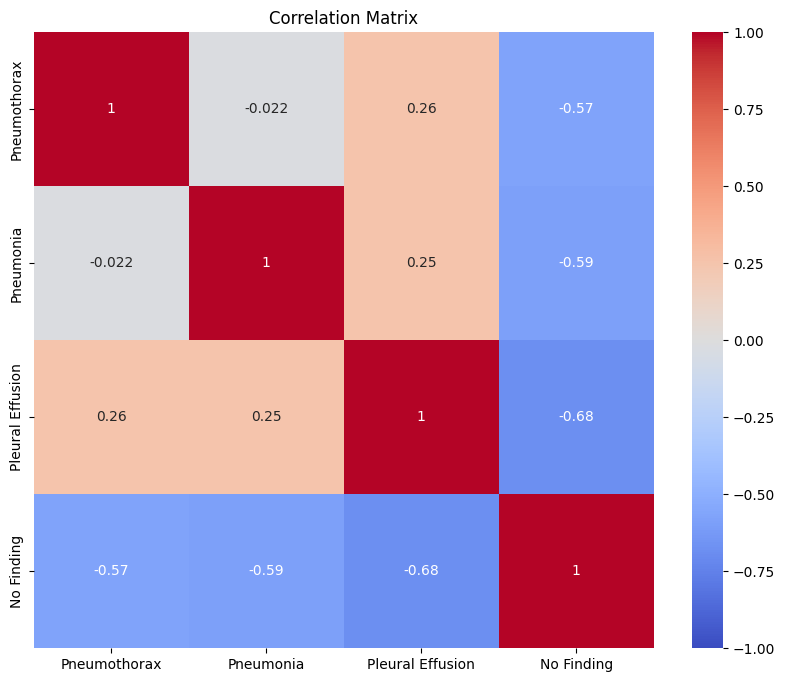

In [ ]:
corr_matrix = dataset_drop.corr()

# Print the correlation matrix
print(corr_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

                  Pneumothorax  Pneumonia  Pleural Effusion  No Finding
Pneumothorax          1.000000   0.117064          0.142203   -0.193843
Pneumonia             0.117064   1.000000          0.229778   -0.194628
Pleural Effusion      0.142203   0.229778          1.000000   -0.490117
No Finding           -0.193843  -0.194628         -0.490117    1.000000


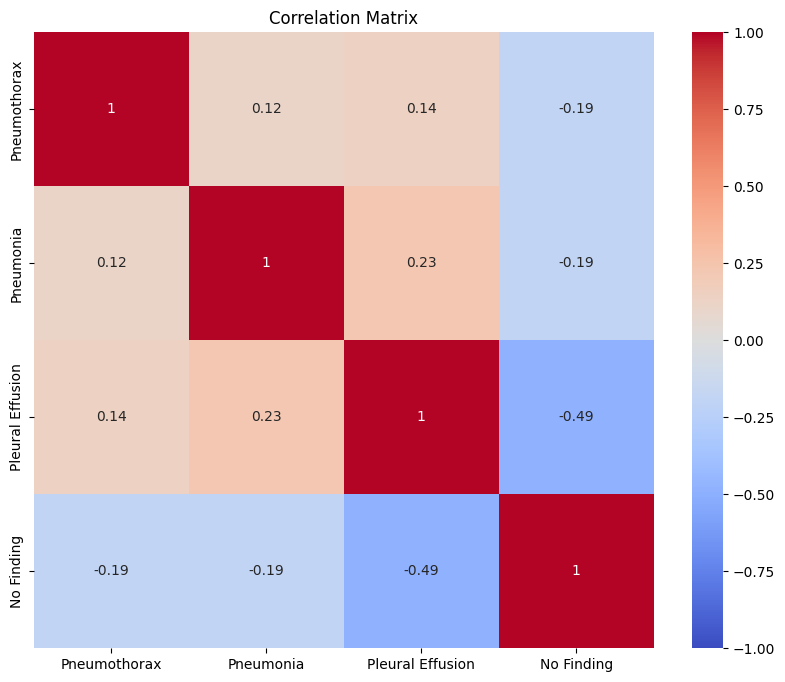

In [ ]:
corr_matrix = test_preds_new.drop(columns=['study_id', 'image_path', 'Pneumonia Probs', 'Pneumothorax Probs', 'Pleural Effusion Probs', 'No Finding Probs']).corr()

# Print the correlation matrix
print(corr_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()